# Stock Price Modelling Regression Experiment 1.0

Build baseline models with default parameters. Evaluate their performance. Save all models

# Modelling Regression Experiment #1.0

- Split data into Train / Validation / Test set
- Create Baseline Models
    - 1) Arima
        - Test for stationarity
        - Find p, q, d terms
        - Model Building
    - 2) Multivariate Arima
        - Causality investigation.
        - Test for stationary
        - Model Building.
        - Test for residuals (errors).
        - Forecasting
        - Model evaluation
    - 3) Random Forest
        - Model Building.
        - Model evaluation against the test set
    - 4) XGBoost
        - Model Building.
        - Model evaluation against the test set
    - 5) kNN
        - Model Building.
        - Model evaluation against the test set
    - 6) SVM
        - Model Building.
        - Model evaluation against the test set
    - 7) LSTM
        - Model Building.
        - Model evaluation against the test set
- Compare their error performace

# 1 Install more libraries

Some libraries in remote Kaggle notebook are missing. They need to be installed 

In [ ]:
!pip install -q yfinance==0.2.28
!pip install -q pmdarima
!pip install -q pandas_datareader

# 2 Loading the libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O


# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

# plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Sklearn libraries
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 3 Download stock data

In [2]:
def get_stock_data(stock_name):
    
    # For time stamps
    from datetime import datetime
    import yfinance as yf
    
    # The tech stocks we'll use for this analysis
    tech_list = [stock_name]

    dict_of_stocks = {}

    end = datetime.now()
    start = datetime(end.year - 10, end.month, end.day)

    for stock in tech_list:
        globals()[stock] = yf.download(stock, start, end)
        dict_of_stocks[tech_list[0]] = globals()[stock]
        

    return dict_of_stocks[tech_list[0]]

In [3]:
main_df = get_stock_data("KRI.AT")

[*********************100%%**********************]  1 of 1 completed


# 4 Inspecting the data

In [12]:
main_df.head(), main_df.tail()

(                 Open       High        Low      Close  Adj Close     Volume
 Date                                                                        
 2013-10-24  18.750000  19.016787  18.658930  18.996786  16.579466  384764800
 2013-10-25  18.975714  19.043928  18.753929  18.784286  16.394009  337792000
 2013-10-28  18.894285  18.964287  18.686071  18.924286  16.516186  550440800
 2013-10-29  19.152500  19.258928  18.376429  18.452856  16.104750  635807200
 2013-10-30  18.557501  18.840000  18.465000  18.746429  16.360964  354163600,
                   Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2023-10-17  176.649994  178.419998  174.800003  177.149994  177.149994   
 2023-10-18  175.580002  177.580002  175.110001  175.839996  175.839996   
 2023-10-19  176.039993  177.839996  175.190002  175.460007  175.460007   
 2023-10-20  175.309998  175.419998  172.639999  172.880005  172.880005   
 20

# 4-1 Performance dataframe for models' error/evaluation

In [13]:
df_model_performances = pd.DataFrame({
    'rmse': [np.NAN, np.NAN, np.NAN, np.NAN, np.NAN, np.NAN, np.NAN, np.NAN, np.NAN, np.NAN]
}, index=['Arima', 'rf', 'rf_tuned', 'XGBoost', 'XGBoost_tuned', 'svm', 'svm_tuned', 'kNN', 'kNN_tuned', 'LSTM'])

# 4-2 Dataset timestamps

In [4]:
#Experiment_1
train_start_time = '2020-01-01'
train_end_time = '2023-08-31' 

validation_start_time = '2023-09-01'
validation_end_time = '2023-09-30'

test_start_time = '2023-10-01'


#Experiment_2
""" train_start_time = '2020-01-01'
train_end_time = '2022-12-31' 

validation_start_time = '2023-01-01'
validation_end_time = '2023-09-30'

test_start_time = '2023-10-01'
 """

#Experiment_3
""" train_start_time = '2018-01-01'
train_end_time = '2022-12-31' 

validation_start_time = '2023-01-01'
validation_end_time = '2023-09-30'

test_start_time = '2023-10-01' """ 


#Experiment_4
""" train_start_time = str(main_df.index[0].year)+"-"+str(main_df.index[0].month)+"-"+str(main_df.index[0].day)
train_end_time = '2022-12-31' 

validation_start_time = '2023-01-01'
validation_end_time = '2023-09-30'

test_start_time = '2023-10-01' """

' train_start_time = str(main_df.index[0].year)+"-"+str(main_df.index[0].month)+"-"+str(main_df.index[0].day)\ntrain_end_time = \'2022-12-31\' \n\nvalidation_start_time = \'2023-01-01\'\nvalidation_end_time = \'2023-09-30\'\n\ntest_start_time = \'2023-10-01\' '

# 5 Statistical Learning - Time Series

In [5]:
def split_dataset_for_arima(main_df, 
                            train_start = '2020-01-01',
                            train_end = '2022-12-31', 
                            validation_start = '2023-01-01',
                            validation_end = '2023-08-31',
                            test_start = '2023-09-01'):


    # Split the data into train, validation, and test sets
    train_set = main_df[(main_df.index >= train_start) & (main_df.index <= train_end)]
    validation_set = main_df[(main_df.index >= validation_start) & (main_df.index <= validation_end)]
    train_and_validation_set = pd.concat([train_set, validation_set], axis=0)
    test_set = main_df[main_df.index >= test_start]


    # Print the sizes of the sets
    print("Train Set Size:", len(train_set))
    print("Validation Set Size:", len(validation_set))
    print("Test Set Size:", len(test_set))

    return train_set, validation_set, train_and_validation_set, test_set

# 5-1. Spliting the dataset for Arima model

In [6]:
train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_arima(main_df, 
                                    train_start = train_start_time,
                                    train_end = train_end_time, 
                                    validation_start = validation_start_time,
                                    validation_end = validation_end_time,
                                    test_start = test_start_time)

Train Set Size: 744
Validation Set Size: 20
Test Set Size: 17


# 6 Baseline Arima

# 6.1 Sources/tutorials

https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

https://blogs.sap.com/2021/05/06/a-multivariate-time-series-modeling-and-forecasting-guide-with-python-machine-learning-client-for-sap-hana/


# 6.2 Dickey Fuller Test

In [7]:
def dickey_fuller_test(df):

    from statsmodels.tsa.stattools import adfuller
    from numpy import log
    result = adfuller(df.Close.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

dickey_fuller_test(train_set)

ADF Statistic: -0.785988
p-value: 0.823203


If the p-value is less than a significance level (e.g. 0.05), you can reject the null hypothesis, indicating that the time series is stationary.

If the p-value is greater than the significance level, you fail to reject the null hypothesis, suggesting that the time series is non-stationary.

The p-value is 0.608091, which is greater than the common significance level of 0.05. Therefore, based on this ADF test, you fail to reject the null hypothesis, suggesting that your time series is likely non-stationary. Non-stationary time series often exhibit trends, seasonality, or other patterns that change over time.

# 6-3 How to find the order of differencing (d) in ARIMA model

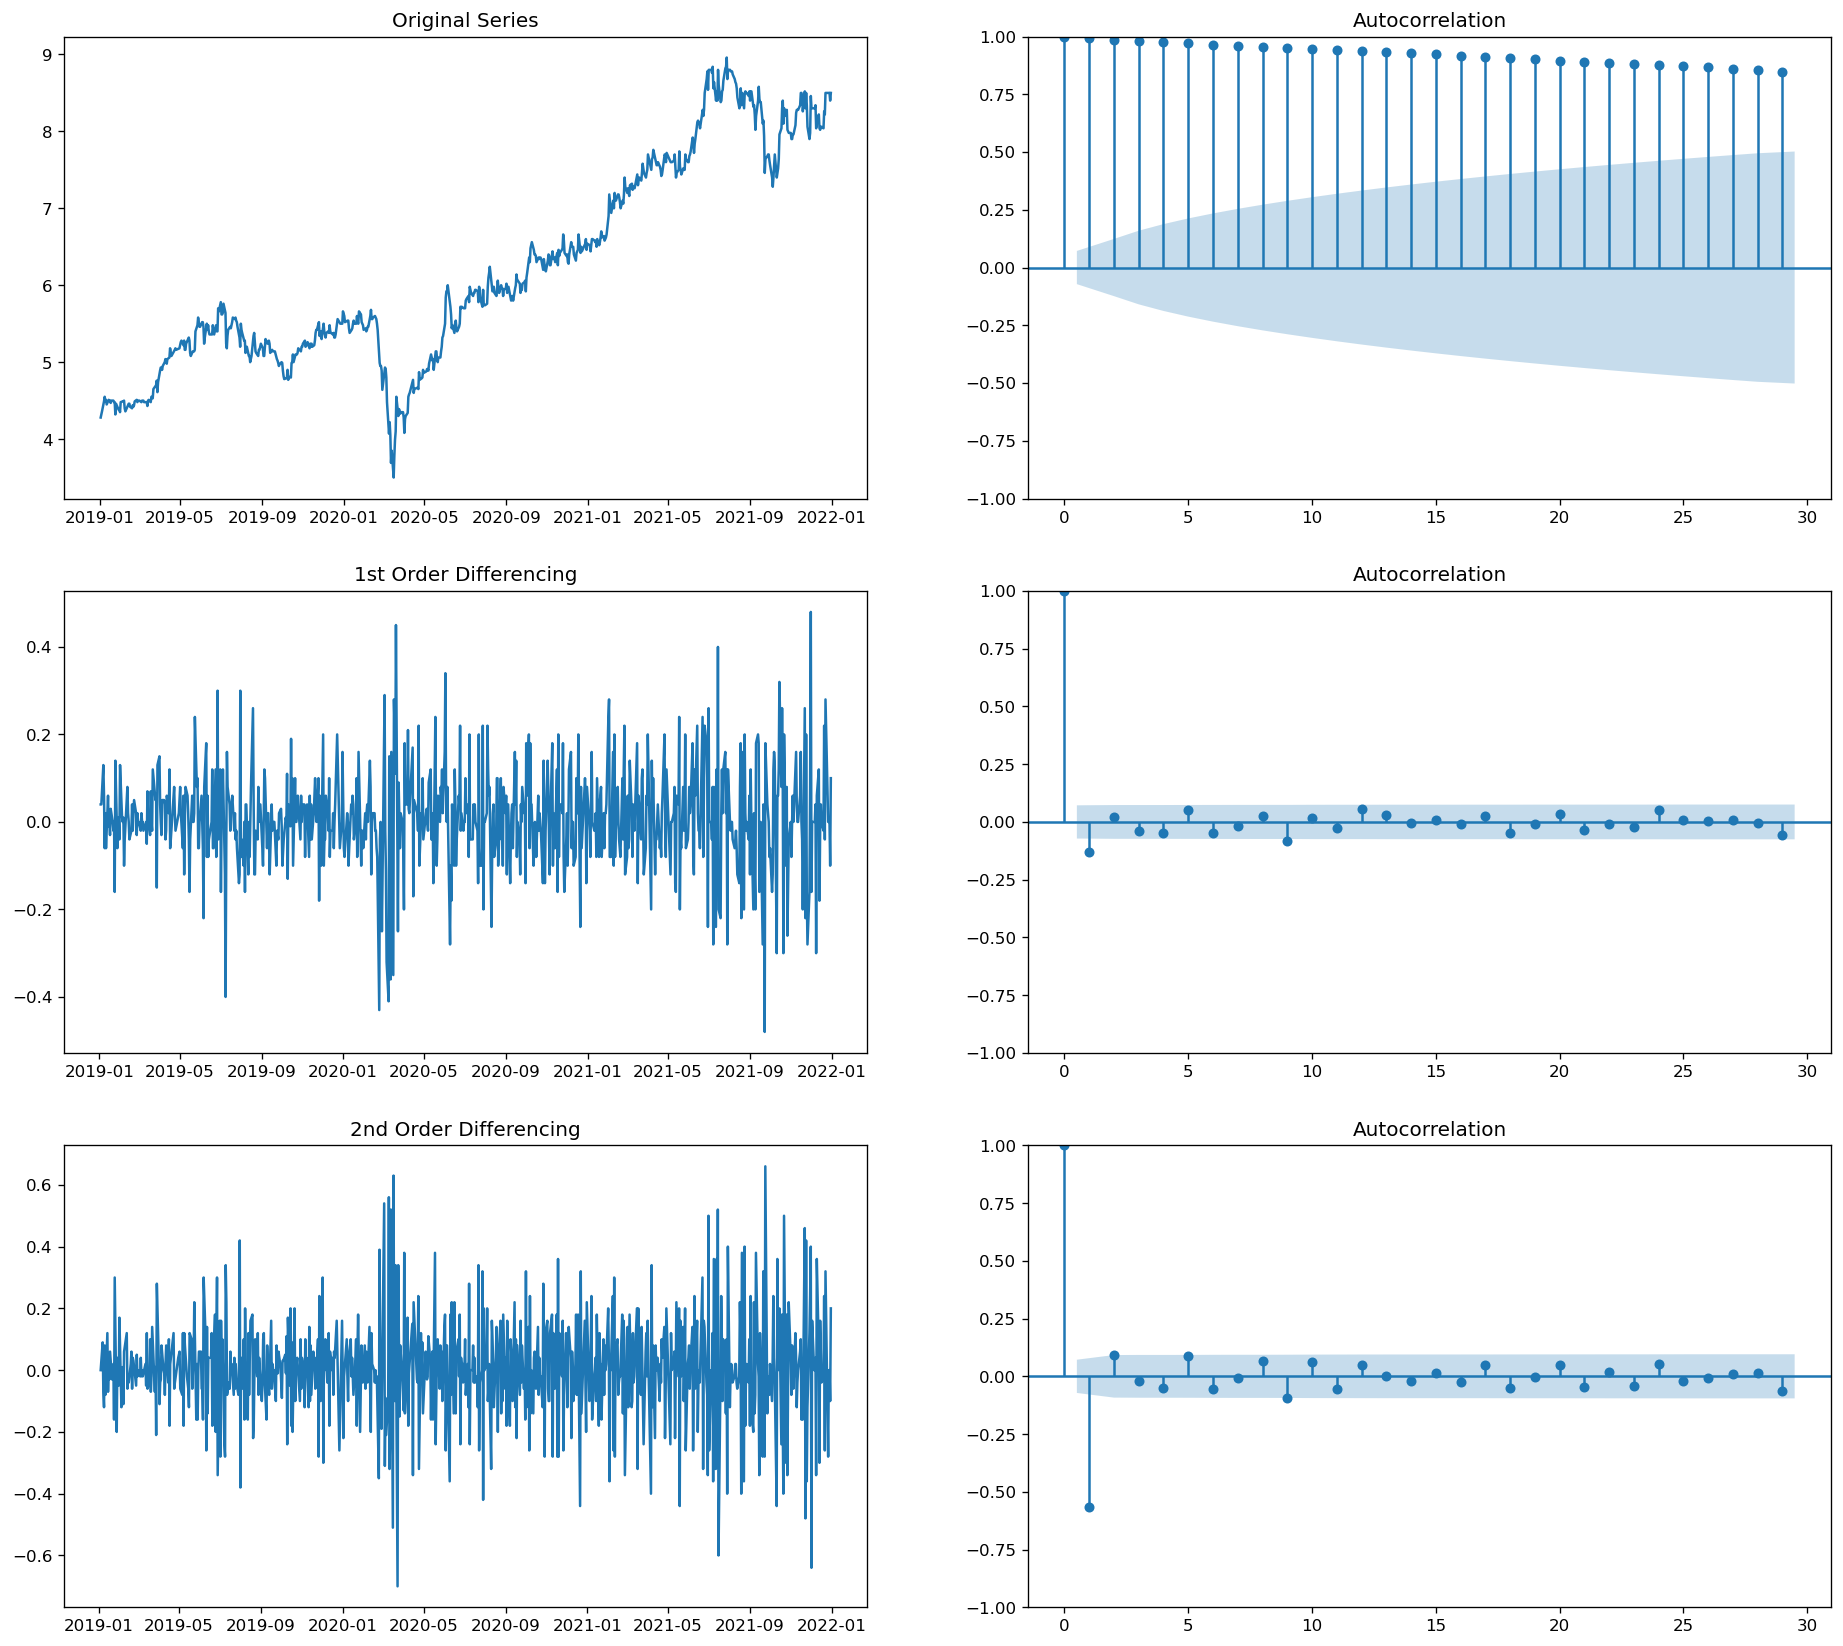

In [8]:
def autocorrelation_plots(df):

    from statsmodels.graphics.tsaplots import plot_acf
    plt.rcParams.update({'figure.figsize':(19,17), 'figure.dpi':120})

    # Original Series
    fig, axes = plt.subplots(3, 2)
    axes[0, 0].plot(df.Close); axes[0, 0].set_title('Original Series')
    plot_acf(df.Close, ax=axes[0, 1])

    # 1st Differencing
    axes[1, 0].plot(df.Close.diff()); axes[1, 0].set_title('1st Order Differencing')
    plot_acf(df.Close.diff().dropna(), ax=axes[1, 1])

    # 2nd Differencing
    axes[2, 0].plot(df.Close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
    plot_acf(df.Close.diff().diff().dropna(), ax=axes[2, 1])

    plt.show()

autocorrelation_plots(train_set)

# 6-4 Adf Test - KPSS test - PP test

In [9]:
from pmdarima.arima.utils import ndiffs

## Adf Test
adf = ndiffs(train_set.Close, test='adf')  # 1

# KPSS test
kpss = ndiffs(train_set.Close, test='kpss')  # 1

# PP test:
pp = ndiffs(train_set.Close, test='pp')  # 1

adf, kpss, pp

(1, 1, 1)

# 6-5 PACF plot

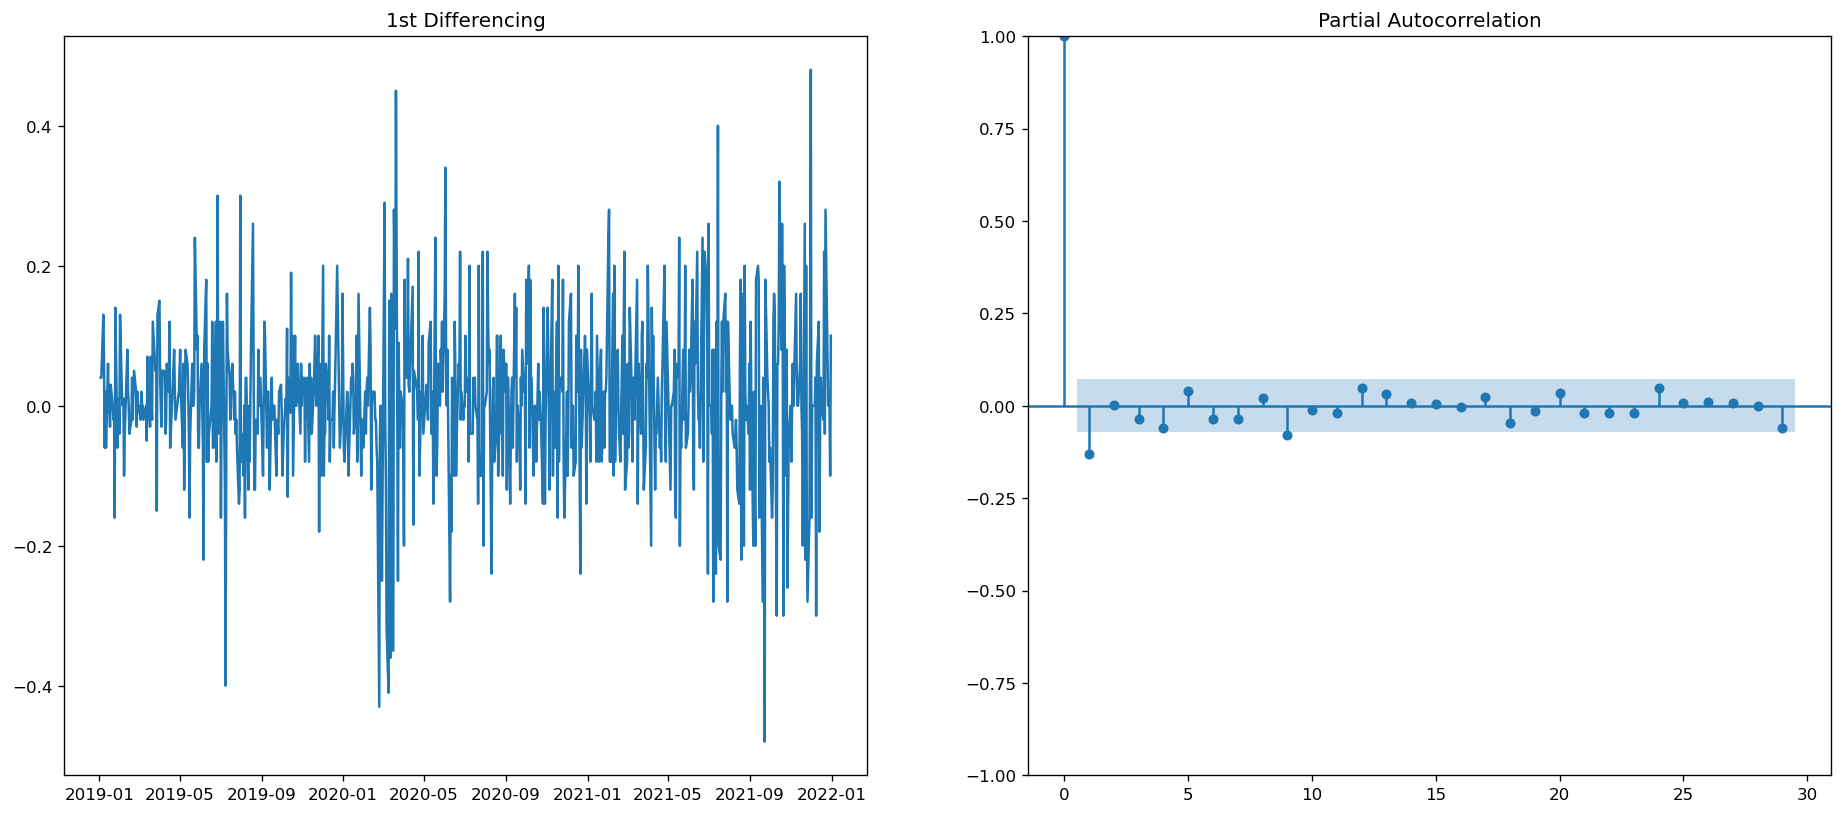

In [10]:
def partial_autocorrelation_plots(df):

    from statsmodels.graphics.tsaplots import plot_pacf

    # PACF plot of 1st differenced series
    plt.rcParams.update({'figure.figsize':(19,8), 'figure.dpi':120})

    fig, axes = plt.subplots(1, 2)
    axes[0].plot(df.Close.diff(1)); axes[0].set_title('1st Differencing')
    axes[1].set(ylim=(0,5))
    plot_pacf(df.Close.diff().dropna(), ax=axes[1])

    plt.show()

partial_autocorrelation_plots(train_set)

# 6-6 Auto Arima to find the best parameters

find the optimal p, q, d orders

source / tutorial at:
https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [11]:
def auto_arima(df):

     import pmdarima as pm

     auto_arima_model = pm.auto_arima(df['Close'], start_p=1, d=None, start_q=1, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False,error_action='ignore',  
                              suppress_warnings=True,
                         stepwise=True, trace=True)
     
     return auto_arima_model

auto_arima_model = auto_arima(train_set)

          

Performing stepwise search to minimize aic


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1118.965, Time=2.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1110.140, Time=0.78 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1120.957, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1120.825, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1110.308, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1118.961, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1116.957, Time=0.76 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1120.598, Time=0.19 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 5.586 seconds


# 6-7 Build Arima model after finding AutoArima parameters

After using AutoArima, lets build the Arima model using statsmodels library

c:\Users\praxitelis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\praxitelis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\praxitelis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   18
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -18.472
Date:                Tue, 24 Oct 2023   AIC                             40.943
Time:                        13:42:17   BIC                             42.610
Sample:                             0   HQIC                            41.109
                                 - 18                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1412      0.448     -0.315      0.753      -1.020       0.737
sigma2         0.5138      0.092      5.608      0.000       0.334       0.693
Ljung-Box (L1) (Q):                   0.35   Jarque-

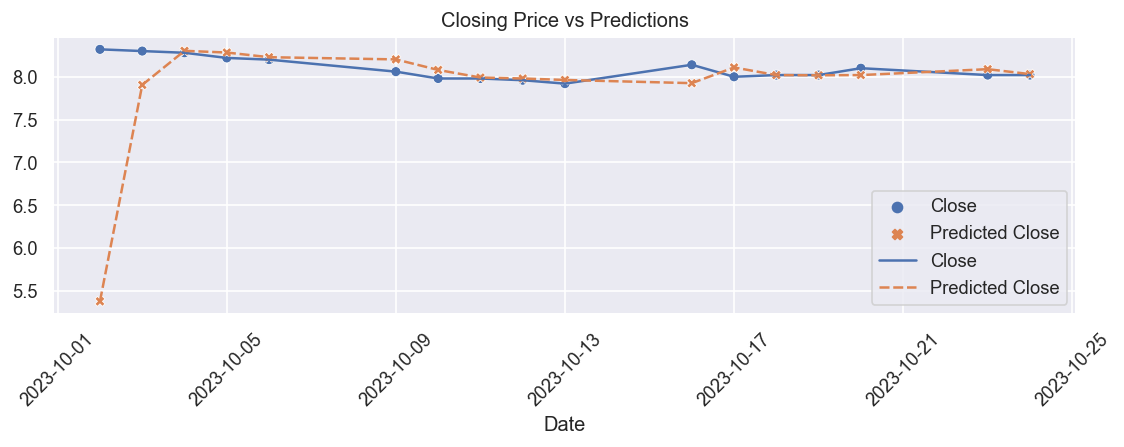

In [14]:
def build_arima_model(validation_set, test_set):

    from statsmodels.tsa.arima.model import ARIMA

    # Fit the ARIMA model into the test set
    df = pd.concat([validation_set[-1:], test_set])

    arima_model = ARIMA(df['Close'], order=(auto_arima_model.order[0], 
                                            auto_arima_model.order[1], 
                                            auto_arima_model.order[2]))

    arima_model_res = arima_model.fit()
    print(arima_model_res.summary())


    # create forecasts
    forecasts =  arima_model_res.predict(start=1, end=len(test_set))

    # evaluate forecasts against test_set
    from sklearn.metrics import mean_squared_error

    mse = mean_squared_error(test_set['Close'], forecasts)
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse}")


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_set.index,
                        'Close': test_set['Close'],
                        'Predicted Close': forecasts
                            })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')

    df_model_performances.loc['Arima'] = rmse

    return arima_model, rmse

arima_model, arima_rmse = build_arima_model(validation_set, test_set)

# 7 Multivariate Time Series


Tutorial / Source:

https://mlpills.dev/time-series/step-by-step-guide-to-multivariate-time-series-forecasting-with-var-models/

https://towardsdatascience.com/a-quick-introduction-on-granger-causality-testing-for-time-series-analysis-7113dc9420d2#:~:text=The%20Granger%20causality%20test%20is,predict%20tomorrow's%20Tesla's%20stock%20price%3F

# 7-1 Test for causation amongst the time series 

Granger Causality tests

In [ ]:
def test_for_causation(train_set):

    from statsmodels.tsa.stattools import grangercausalitytests

    maxlag = 20
    variables=train_set.columns
    matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for col in matrix.columns:
        for row in matrix.index:
            test_result = grangercausalitytests(train_set[[row, col]], maxlag=20, verbose=False)
            p_values = [round(test_result[i+1][0]['ssr_chi2test'][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            matrix.loc[row, col] = min_p_value
    matrix.columns = [var + '_x' for var in variables]
    matrix.index = [var + '_y' for var in variables]
    print(matrix)

test_for_causation(train_set)

From the result above, each column represents a predictor x of each variable and each row represents the response y and the p-value of each pair of variables are shown in the matrix.

# 7-2 Test for stationarity -  Ad fuller test

In [ ]:
def test_for_stationarity(train_set):

    from statsmodels.tsa.stattools import adfuller

    def adfuller_test(df, series, sig=0.05):
        res = adfuller(df[series], autolag='AIC')    
        p_value = round(res[1], 3)

        if p_value <= sig:
            print(f" {series} : P-Value = {p_value} => Stationary. ")
        else:
            print(f" {series} : P-Value = {p_value} => Non-stationary.")

    for column in train_set.columns:
        adfuller_test(train_set, column)

test_for_stationarity(train_set)

# 7-3 Transform the series to make it stationary, if needed

In [ ]:
def adfuller_test(df, series, sig=0.05):
        
        from statsmodels.tsa.stattools import adfuller
        res = adfuller(df[series], autolag='AIC')    
        p_value = round(res[1], 3)

        if p_value <= sig:
            print(f" {series} : P-Value = {p_value} => Stationary. ")
        else:
            print(f" {series} : P-Value = {p_value} => Non-stationary.")


data_differenced = train_set.diff().dropna()
for column in data_differenced.columns:
    adfuller_test(data_differenced, column)

# 7-4 Model Building

In [ ]:
from statsmodels.tsa.api import VAR


var_model = VAR(train_set.diff().dropna())
x = var_model.select_order(maxlags=21)
x.summary()

# 7-5 Find the best lag

In [ ]:
from statsmodels.tsa.api import VAR

var_model = VAR(train_set.diff().dropna())
aic = 99999
best_lag = 0
for i in range(1,31):
    result = var_model.fit(i)
    if result.aic < aic:
        aic = result.aic
        best_lag = i

print("best lag: ", best_lag)

AIC drops at the above lag order. So it is better to keep lag upto that value.

In [ ]:
model_var_fitted = var_model.fit(21)
#model_var_fitted.summary()

# 7-6 Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors).

What does this mean to us?

If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.

So, checking for serial correlation is to ensure that the model is sufficiently able to explain the variances and patterns in the time series.

Alright, coming back to topic.

A common way of checking for serial correlation of errors can be measured using the Durbin Watson’s Statistic.

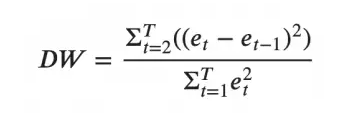

The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_var_fitted.resid)

 
for col, val in zip(train_set.diff().dropna().columns, out):
    print(col, ':', round(val, 2))

# 7-7 How to Forecast VAR model using statsmodels

In [ ]:
lag_order = model_var_fitted.k_ar

# Input data for forecasting
forecast_input = pd.concat([validation_set[-lag_order-1:], test_set])
forecast_input_differenced = forecast_input.copy().diff().dropna()

# Forecast
nobs = forecast_input_differenced.shape[0]
fc = model_var_fitted.forecast(y = forecast_input_differenced.values, steps=nobs)
df_forecast = pd.DataFrame(fc, index = forecast_input_differenced.index, columns = forecast_input.columns + '_1d')
df_forecast.tail()

# 7-8 Invert the transformation to get the real forecast

In [ ]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

forecast_input = pd.concat([validation_set[-lag_order:], test_set])
df_results = invert_transformation(forecast_input, df_forecast, second_diff=False)

# Plot of Forecast vs Actuals

In [ ]:
fig, axes = plt.subplots(nrows=int(len(forecast_input.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(forecast_input.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    forecast_input[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();


# 8 Machine Learning models

# Prepare the closing price target variable

# 8-1 Split the dataset for ML

In [23]:
def split_dataset_for_ml(main_df, 
                         train_start = '2023-01-01',
                         train_end = '2023-08-31', 
                         validation_start = '2023-09-01',
                         validation_end = '2023-09-30',
                         test_start = '2023-10-01'):
    
    
    # Prepare the closing price as target variable    
    main_df['target'] = main_df['Close'].shift(-1)


    # Split the data into train, validation, and test sets
    train_set = main_df[(main_df.index >= train_start) & (main_df.index <= train_end)]
    validation_set = main_df[(main_df.index >= validation_start) & (main_df.index <= validation_end)]
    train_and_validation_set = pd.concat([train_set, validation_set], axis=0)

    test_set = main_df[main_df.index >= test_start]
    test_set = test_set[:-1]


    # Print the sizes of the sets
    print("Train Set Size:", len(train_set))
    print("Validation Set Size:", len(validation_set))
    print("Test Set Size:", len(test_set))

    return train_set, validation_set, train_and_validation_set, test_set

In [24]:
train_set, validation_set, train_and_validation_set, test_set = split_dataset_for_ml(main_df.copy(), 
                            train_start = train_start_time,
                            train_end = train_end_time, 
                            validation_start = validation_start_time,
                            validation_end = validation_end_time,
                            test_start = test_start_time)

Train Set Size: 923
Validation Set Size: 20
Test Set Size: 15


# 8-3 Baseline Random Forest Model

RMSE: 1.7714441546311166


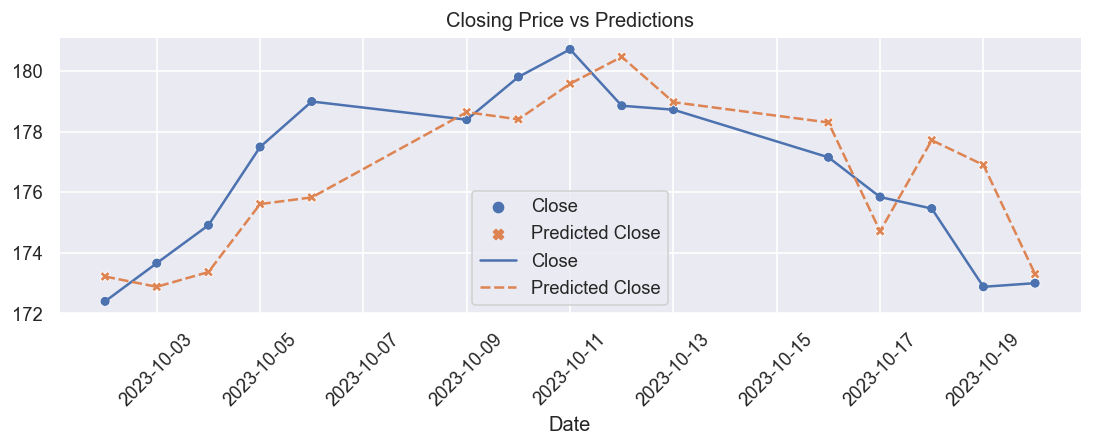

In [25]:
def build_random_forest_baseline_model(train_set, test_set):

    from sklearn.ensemble import RandomForestRegressor    
    
    #scaling the data before modeling
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_set)
    train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)
    
    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)

    
    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']
    
    
    # Train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=4)
    rf_model.fit(X_train, y_train)

    # Make predictions using the trained model
    y_pred = rf_model.predict(X_test)
    
    
    # unscale y_pred_diff
    train_data = train_set
    test_data = test_set
    y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
    
    test_data["y_pred"] = y_pred
    
    
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                       'Close': test_data['target'],
                       'Predicted Close': test_data['y_pred']
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')
    
    
    # Save the model performance and model's name
    df_model_performances.loc["rf"] = rmse
    
    return rf_model, rmse

rf_model_baseline, rf_model_rmse = build_random_forest_baseline_model(train_set.copy(), test_set.copy())

# 8-3-1 Tuned Random Forest

100%|██████████| 250/250 [02:22<00:00,  1.76trial/s, best loss: 2.7490814940415995]
{'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 102}
1.6739442586658213 rmse


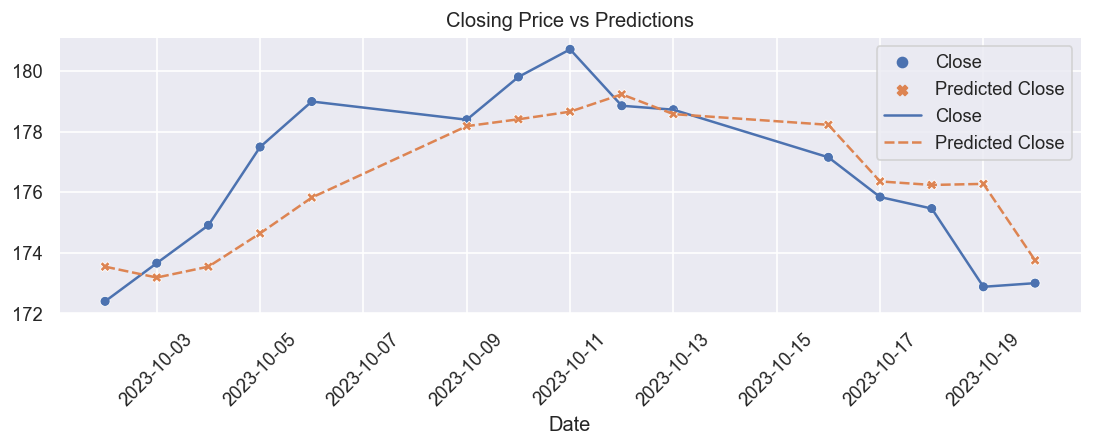

In [26]:
def randomforest_tuning(train_set, validation_set, test_set):

    from hyperopt import hp, tpe, fmin, Trials, space_eval
    from sklearn.ensemble import RandomForestRegressor

    # Set a random seed
    ''' 
    By setting the random seed with np.random.seed(42), 
    you ensure that the random sampling in Hyperopt is reproducible across runs 
    as long as the seed remains the same.
    '''
    np.random.seed(42)

    # Define the search space for hyperparameters
    space = {
        'n_estimators': hp.choice('n_estimators', range(100, 200, 2)),
        'max_depth': hp.choice('max_depth', range(1, 6)),
        'min_samples_split': hp.choice('min_samples_split', range(2, 5)),
        'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 5)),
        'max_features': hp.choice('max_features', ['sqrt', 'log2'])
    }

    # Define the objective function to minimize (negative mean squared error)
    def objective(params):

        #scaling the data before modeling
        scaler = StandardScaler()
        scaled_array = scaler.fit_transform(train_set)
        train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)
        
        scaled_array = scaler.transform(validation_set)
        validation_data = pd.DataFrame(scaled_array, columns=validation_set.columns, index=validation_set.index)

        
        # Prepare the data for Random Forest
        X_train = train_data.drop(['target'], axis=1, inplace=False)
        y_train = train_data['target']

        X_test = validation_data.drop(['target'], axis=1, inplace=False)
        y_test = validation_data['target']

        model = RandomForestRegressor(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            max_features=params['max_features'],
            random_state=42,
            n_jobs=4
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # unscale y_pred_diff
        train_data = train_set
        validation_data = validation_set
        y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
        y_test = validation_data['target']

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return rmse

    # Create an instance of the Trials class to keep track of the results
    trials = Trials()

    # Run the hyperparameter search using the TPE algorithm
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=250,
                trials=trials,
                rstate=np.random.default_rng(42))

    # Get the best hyperparameters
    best_params = space_eval(space, best)
    print(best_params)

    # Train the final model with the best hyperparameters

    #scaling the data before modeling
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_set)
    train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)

    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)


    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']


    final_model = RandomForestRegressor(**best_params, random_state=42)
    final_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = final_model.predict(X_test)

    # unscale y_pred_diff
    train_data = train_set
    test_data = test_set
    y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
    y_test = test_data['target']

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("{} rmse".format(rmse))


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                       'Close': test_data['target'],
                       'Predicted Close': y_pred
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')

    # Save the model performance and model name
    df_model_performances.loc["rf_tuned"] = rmse

    return final_model, rmse

rf_model_tuned, rf_tuned_rmse = randomforest_tuning(train_set.copy(), validation_set.copy(), test_set.copy())

# 8-4 Baseline XGBoost

RMSE: 2.443300205360966


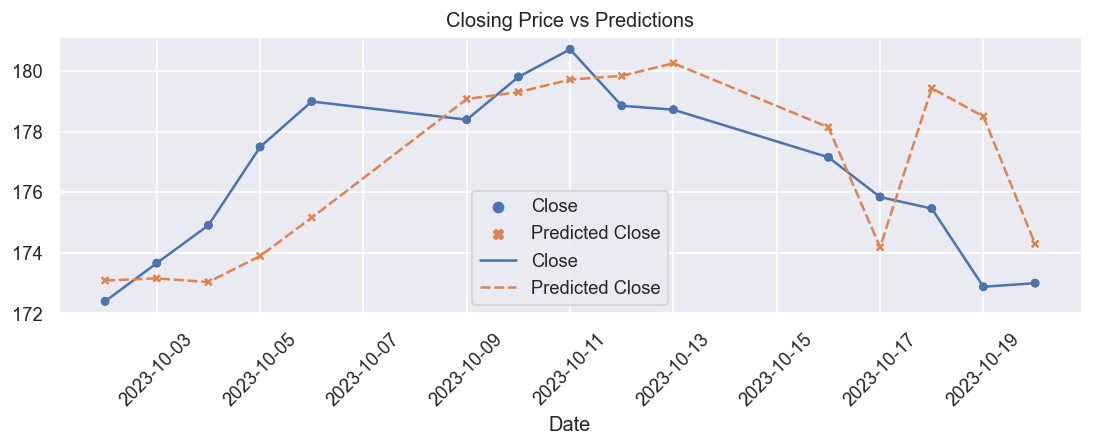

In [28]:
def build_xgboost_baseline_model(train_set, test_set):

    import xgboost as xgb
    
    #scaling the data before modeling
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_set)
    train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)
    
    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)

    
    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']
    
    
    # Train the Random Forest model
    xgb_model = xgb.XGBRegressor(n_estimators=100)
    xgb_model.fit(X_train, y_train)

    # Make predictions using the trained model
    y_pred = xgb_model.predict(X_test)
    
    test_set["y_pred"] = y_pred
    
    
    # unscale y_pred_diff
    train_data = train_set
    test_data = test_set
    y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
    
    test_data["y_pred"] = y_pred
    
    
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")


    #plot Close and predicted Close price
    
    plot_df = pd.DataFrame({'Date': test_set.index,
                       'Close': test_set['target'],
                       'Predicted Close': test_set['y_pred']
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')
    
    # Save the model performance and model name
    df_model_performances.loc["XGBoost"] = rmse
    
    return xgb_model, rmse

xgb_model_baseline, xgb_model_rmse = build_xgboost_baseline_model(train_set.copy(), test_set.copy())

# 8-4-1 Tuned XGBoost

100%|██████████| 250/250 [03:49<00:00,  1.09trial/s, best loss: 2.3766496413649136]
{'gamma': 0.7000000000000001, 'learning_rate': 0.15000000000000002, 'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 388, 'subsample': 0.55}
1.8694302568226706 rmse


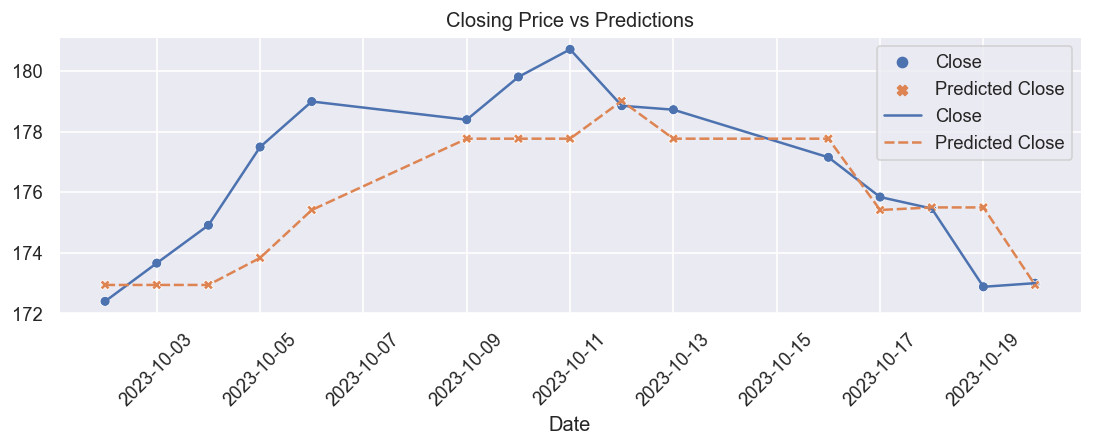

In [29]:
def xgboost_tuning(train_set, validation_set, test_set):

    from hyperopt import hp, tpe, fmin, Trials, space_eval
    import xgboost as xgb

    # Set a random seed
    ''' 
    By setting the random seed with np.random.seed(42), 
    you ensure that the random sampling in Hyperopt is reproducible across runs 
    as long as the seed remains the same.
    '''
    np.random.seed(42)

    # Define the search space for hyperparameters
    space = {
        'n_estimators': hp.choice('n_estimators', range(100, 400, 2)),
        'max_depth': hp.choice('max_depth', range(1, 15)),
        'learning_rate':  hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'min_child_weight': hp.choice('min_child_weight', range(1, 11)),
        'gamma': hp.quniform('gamma', 0.4, 1, 0.05),
    }

    # Define the objective function to minimize (negative mean squared error)
    def objective(params):

        #scaling the data before modeling
        scaler = StandardScaler()
        scaled_array = scaler.fit_transform(train_set)
        train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)
        
        scaled_array = scaler.transform(validation_set)
        validation_data = pd.DataFrame(scaled_array, columns=validation_set.columns, index=validation_set.index)

        
        # Prepare the data for Random Forest
        X_train = train_data.drop(['target'], axis=1, inplace=False)
        y_train = train_data['target']

        X_test = validation_data.drop(['target'], axis=1, inplace=False)
        y_test = validation_data['target']

        model = xgb.XGBRegressor(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            min_child_weight=params['min_child_weight'],
            gamma=params['gamma'],
            objective='reg:squarederror'
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # unscale y_pred_diff
        train_data = train_set
        validation_data = validation_set
        y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
        y_test = validation_data['target']

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return rmse

    # Create an instance of the Trials class to keep track of the results
    trials = Trials()

    # Run the hyperparameter search using the TPE algorithm
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=250,
                trials=trials,
                rstate=np.random.default_rng(42))

    # Get the best hyperparameters
    best_params = space_eval(space, best)
    print(best_params)

    # Train the final model with the best hyperparameters

    #scaling the data before modeling
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_set)
    train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)

    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)


    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']


    final_model = xgb.XGBRegressor(**best_params, random_state=42)
    final_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = final_model.predict(X_test)

    # unscale y_pred_diff
    train_data = train_set
    test_data = test_set
    y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
    y_test = test_data['target']

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("{} rmse".format(rmse))


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                       'Close': test_data['target'],
                       'Predicted Close': y_pred
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')


    # Save the model performance and model name
    df_model_performances.loc["XGBoost_tuned"] = rmse


    return final_model, rmse

xgb_model_tuned, xgboost_tuned_rmse = xgboost_tuning(train_set.copy(), validation_set.copy(), test_set.copy())

# 8-5 Baseline SVM

In [ ]:
def build_svm_baseline_model(train_set, test_set):
    
    from sklearn.svm import SVR

    #scaling the data before modeling
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_set)
    train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)
    
    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)

    
    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']
    
    
    # Train the Random Forest model
    svm = SVR(kernel='linear')
    svm.fit(X_train, y_train)

    # Make predictions using the trained model
    y_pred = svm.predict(X_test)
    
    # unscale y_pred_diff
    train_data = train_set
    test_data = test_set
    y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
    
    test_data["y_pred"] = y_pred
    
    
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")


    #plot Close and predicted Close price
    
    plot_df = pd.DataFrame({'Date': test_set.index,
                       'Close': test_set['target'],
                       'Predicted Close': test_set['y_pred']
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')
    
    # Save the model performance and model's name
    df_model_performances.loc["svm"] = rmse
    
    return svm, rmse

svm_model_baseline, svm_model_rmse = build_svm_baseline_model(train_set.copy(), validation_set.copy(), test_set.copy())

# 8-5-1 Tuned SVM

In [ ]:
def svr_tuning(train_set, validation_set, test_set):

    from hyperopt import hp, tpe, fmin, Trials, space_eval
    from sklearn.svm import SVR

    # Set a random seed
    ''' 
    By setting the random seed with np.random.seed(42), 
    you ensure that the random sampling in Hyperopt is reproducible across runs 
    as long as the seed remains the same.
    '''
    np.random.seed(42)

    # Define the search space for hyperparameters
    space = {
        'kernel': hp.choice('kernel', ['linear', 'rbf', 'sigmoid']),
        'degree':  hp.choice('degree', range(1, 6)),
        'C': hp.uniform('C', 0, 1),  # C parameter (log-uniform search space)
        'epsilon': hp.loguniform('epsilon', -4, 1),  # Epsilon (log-uniform search space)

    }

    # Define the objective function to minimize (negative mean squared error)
    def objective(params):

        #scaling the data before modeling
        scaler = StandardScaler()
        scaled_array = scaler.fit_transform(train_set)
        train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)
        
        scaled_array = scaler.transform(validation_set)
        validation_data = pd.DataFrame(scaled_array, columns=validation_set.columns, index=validation_set.index)

        
        # Prepare the data for Random Forest
        X_train = train_data.drop(['target'], axis=1, inplace=False)
        y_train = train_data['target']

        X_test = validation_data.drop(['target'], axis=1, inplace=False)
        y_test = validation_data['target']

        model = SVR(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # unscale y_pred_diff
        train_data = train_set
        validation_data = validation_set
        y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
        y_test = validation_data['target']

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return rmse

    # Create an instance of the Trials class to keep track of the results
    trials = Trials()

    # Run the hyperparameter search using the TPE algorithm
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=250,
                trials=trials,
                rstate=np.random.default_rng(42))


    # Get the best hyperparameters
    best_params = space_eval(space, best)
    print(best_params)

    # Train the final model with the best hyperparameters

    #scaling the data before modeling
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_set)
    train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)

    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)


    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']


    final_model = SVR(**best_params)
    final_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = final_model.predict(X_test)

    # unscale y_pred_diff
    train_data = train_set
    test_data = test_set
    y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
    y_test = test_data['target']

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("{} rmse".format(rmse))

    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                       'Close': test_data['target'],
                       'Predicted Close': y_pred
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')


    # Save the model performance and model name
    df_model_performances.loc["svm_tuned"] = rmse


    return final_model, rmse

svm_model_tuned, svm_tuned_rmse = svr_tuning(train_set.copy(), validation_set.copy(), test_set.copy())

# 8-6 Baseline kNN

In [ ]:
def build_knn_baseline_model(train_set, test_set):
    
    from sklearn.neighbors import KNeighborsRegressor

    #scaling the data before modeling
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_set)
    train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)
    
    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)

    
    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']
    
    
    # Train the Random Forest model
    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(X_train, y_train)

    # Make predictions using the trained model
    y_pred = knn.predict(X_test)
    
    # unscale y_pred_diff
    train_data = train_set
    test_data = test_set
    y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
    
    test_data["y_pred"] = y_pred
    
    
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")


    #plot Close and predicted Close price
    
    plot_df = pd.DataFrame({'Date': test_set.index,
                       'Close': test_set['target'],
                       'Predicted Close': test_set['y_pred']
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')
    
    # Save the model performance and model's name
    df_model_performances.loc["kNN"] = rmse
    
    return knn, rmse

knn_model_baseline, knn_model_rmse = build_knn_baseline_model(train_set.copy(), validation_set.copy(), test_set.copy())

# 8-6-1 Tuned kNN

In [ ]:
def kNN_tuning(train_set, validation_set, test_set):

    from hyperopt import hp, tpe, fmin, Trials, space_eval
    from sklearn.neighbors import KNeighborsRegressor

    # Set a random seed
    ''' 
    By setting the random seed with np.random.seed(42), 
    you ensure that the random sampling in Hyperopt is reproducible across runs 
    as long as the seed remains the same.
    '''
    np.random.seed(42)

    # Define the search space for hyperparameters
    space = {
        'n_neighbors': hp.choice('n_neighbors', range(1, 21)),  # Number of neighbors (integer values)
        'weights': hp.choice('weights', ['uniform', 'distance']),
        'p': hp.quniform('p', 1, 2, 1),  # Minkowski power parameter (integer values)
    }

    # Define the objective function to minimize (negative mean squared error)
    def objective(params):

        #scaling the data before modeling
        scaler = StandardScaler()
        scaled_array = scaler.fit_transform(train_set)
        train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)
        
        scaled_array = scaler.transform(validation_set)
        validation_data = pd.DataFrame(scaled_array, columns=validation_set.columns, index=validation_set.index)

        
        # Prepare the data for Random Forest
        X_train = train_data.drop(['target'], axis=1, inplace=False)
        y_train = train_data['target']

        X_test = validation_data.drop(['target'], axis=1, inplace=False)
        y_test = validation_data['target']

        model = KNeighborsRegressor(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # unscale y_pred_diff
        train_data = train_set
        validation_data = validation_set
        y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
        y_test = validation_data['target']

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return rmse

    # Create an instance of the Trials class to keep track of the results
    trials = Trials()

    # Run the hyperparameter search using the TPE algorithm
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=250,
                trials=trials,
                rstate=np.random.default_rng(42))


    # Get the best hyperparameters
    best_params = space_eval(space, best)
    print(best_params)

    # Train the final model with the best hyperparameters

    #scaling the data before modeling
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(train_set)
    train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)

    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)


    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']


    final_model = KNeighborsRegressor(**best_params)
    final_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = final_model.predict(X_test)

    # unscale y_pred_diff
    train_data = train_set
    test_data = test_set
    y_pred = (y_pred * train_data['Close'].std()) + train_data['Close'].mean()
    y_test = test_data['target']

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("{} rmse".format(rmse))


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                       'Close': test_data['target'],
                       'Predicted Close': y_pred
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')

    # Save the model performance and model's name
    df_model_performances.loc["kNN_tuned"] = rmse

    return final_model, rmse

knn_model_tuned, knn_tuned_rmse = kNN_tuning(train_set.copy(), validation_set.copy(), test_set.copy())

# 8-7 Baseline LSTM

In [ ]:
def build_lstm_baseline_model(train_set, test_set):
    
    from tensorflow import keras
    from sklearn.preprocessing import MinMaxScaler

    # Set a random seed
    np.random.seed(42)

    #scaling the data before modeling
    scaler = MinMaxScaler()
    scaled_array = scaler.fit_transform(train_set)
    train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)
    
    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)

    
    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']
    
    
    # build the LSTM model
    lstm = keras.Sequential()
    lstm.add(keras.layers.LSTM(20, input_shape=(X_train.shape[1], 1)))
    lstm.add(keras.layers.Dense(1))
    
    # Compile the model
    lstm.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the Model
    lstm.fit(X_train, y_train, epochs=20, batch_size=30, verbose=0)

    # Make predictions using the trained model
    y_pred = lstm.predict(X_test)
    
    # unscale y_pred_diff
    train_data = train_set
    test_data = test_set
    y_pred = (y_pred * (train_data['Close'].max() - train_data['Close'].min())) + train_data['Close'].min()
    
    test_data["y_pred"] = y_pred
    
    
    # Calculate RMSE (Root Mean Squared Error) to evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(test_data["target"], test_data["y_pred"]))
    print(f"RMSE: {rmse}")


    #plot Close and predicted Close price
    
    plot_df = pd.DataFrame({'Date': test_set.index,
                       'Close': test_set['target'],
                       'Predicted Close': test_set['y_pred']
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')
    
    # Save the model performance and model name
    df_model_performances.loc["LSTM"] = rmse
    
    return lstm, rmse

lstm_model_baseline, lstm_model_rmse = build_lstm_baseline_model(train_set.copy(), validation_set.copy(), test_set.copy())

# 8-7-1 Tuned LSTM

In [ ]:
def LSTM_tuning(train_set, validation_set, test_set):

    from hyperopt import hp, tpe, fmin, Trials, space_eval
    import keras
    from keras.models import Sequential
    from keras.layers import LSTM, Dense
    from sklearn.preprocessing import MinMaxScaler

    # Set a random seed
    ''' 
    By setting the random seed with np.random.seed(42), 
    you ensure that the random sampling in Hyperopt is reproducible across runs 
    as long as the seed remains the same.
    '''
    np.random.seed(42)

    # Define the search space for hyperparameters
    space = {
    'lstm_units': hp.choice('lstm_units', range(5, 51, 2)),
    'learning_rate': hp.quniform('learning_rate', 0.025, 0.5, 0.005),
    'batch_size': hp.choice('batch_size', range(8, 65, 4)),
    'epochs': hp.choice('epochs', range(10, 51, 5))
}

    # Define the objective function to minimize (negative mean squared error)
    def objective(params):

        #scaling the data before modeling
        scaler = MinMaxScaler()
        scaled_array = scaler.fit_transform(train_set)
        train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)
        
        scaled_array = scaler.transform(validation_set)
        validation_data = pd.DataFrame(scaled_array, columns=validation_set.columns, index=validation_set.index)

        
        # Prepare the data for Random Forest
        X_train = train_data.drop(['target'], axis=1, inplace=False)
        y_train = train_data['target']

        X_test = validation_data.drop(['target'], axis=1, inplace=False)
        y_test = validation_data['target']

        model = Sequential()
        model.add(LSTM(units=params['lstm_units'], input_shape=(X_train.shape[1], 1)))
        model.add(Dense(1))
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']), loss='mean_squared_error')
        model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
        y_pred = model.predict(X_test)

        # unscale y_pred_diff
        train_data = train_set
        validation_data = validation_set
        y_pred = (y_pred * (train_data['Close'].max() - train_data['Close'].min())) + train_data['Close'].min()
        y_test = validation_data['target']

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        return rmse

    # Create an instance of the Trials class to keep track of the results
    trials = Trials()

    # Run the hyperparameter search using the TPE algorithm
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=250,
                trials=trials,
                rstate=np.random.default_rng(42))


    # Get the best hyperparameters
    best_params = space_eval(space, best)
    print(best_params)

    # Train the final model with the best hyperparameters

    #scaling the data before modeling
    scaler = MinMaxScaler()
    scaled_array = scaler.fit_transform(train_set)
    train_data = pd.DataFrame(scaled_array, columns=train_set.columns, index=train_set.index)

    scaled_array = scaler.transform(test_set)
    test_data = pd.DataFrame(scaled_array, columns=test_set.columns, index=test_set.index)


    # Prepare the data for Random Forest
    X_train = train_data.drop(['target'], axis=1, inplace=False)
    y_train = train_data['target']

    X_test = test_data.drop(['target'], axis=1, inplace=False)
    y_test = test_data['target']


    final_model = Sequential()
    final_model.add(LSTM(units=best_params['lstm_units'], input_shape=(X_train.shape[1], 1)))
    final_model.add(Dense(1))
    final_model.compile(optimizer=keras.optimizers.Adam(learning_rate=best_params['learning_rate']), loss='mean_squared_error')
    final_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

    # Make predictions on the test set
    y_pred = final_model.predict(X_test)

    # unscale y_pred_diff
    train_data = train_set
    test_data = test_set
    y_pred = (y_pred * (train_data['Close'].max() - train_data['Close'].min())) + train_data['Close'].min()
    y_test = test_data['target']
    test_data["y_pred"] = y_pred

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("{} rmse".format(rmse))


    #plot Close and predicted Close price
    plot_df = pd.DataFrame({'Date': test_data.index,
                       'Close': test_data['target'],
                       'Predicted Close': test_data["y_pred"]
                           })


    my_plot = sns.set(rc={'figure.figsize':(11, 3)})
    plt.figure()
    my_plot = sns.scatterplot(plot_df)
    my_plot = sns.lineplot(plot_df)
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
    my_plot.set(title='Closing Price vs Predictions')

    # Save the model performance and model's name
    df_model_performances.loc["LSTM_tuned"] = rmse

    return final_model, rmse

lstm_model_tuned, lstm_tuned_rmse = LSTM_tuning(train_set, validation_set, test_set)

# 9 Evaluate Models' performances

In [ ]:
df_model_performances = df_model_performances.sort_values(by='rmse')
print(df_model_performances.sort_values(by='rmse'))

# Save the dataframe to a CSV file
df_model_performances.to_csv('df_model_performances_exp1.0.csv', index=True)

# 10 Save the models

In [ ]:
import pickle
import os

""" # directory we want to create
directory_path = '/models'

# Check if the directory already exists
if not os.path.exists(directory_path):
    # If it doesn't exist, create it
    os.makedirs(directory_path) """

pickle.dump(knn_model_baseline, open('knn_model_baseline_exp_1.0.pkl', 'wb'))
pickle.dump(svm_model_baseline, open('svm_model_baseline_exp_1.0.pkl', 'wb'))
pickle.dump(xgb_model_baseline, open('xgb_model_baseline_exp_1.0.pkl', 'wb'))
pickle.dump(rf_model_baseline, open('rf_model_baseline_exp_1.0.pkl', 'wb'))

pickle.dump(knn_model_tuned, open('knn_model_tuned_exp_1.0.pkl', 'wb'))
pickle.dump(svm_model_tuned, open('svm_model_tuned_exp_1.0.pkl', 'wb'))
pickle.dump(xgb_model_tuned, open('xgb_model_tuned_exp_1.0.pkl', 'wb'))
pickle.dump(rf_model_tuned, open('rf_model_tuned_exp_1.0.pkl', 'wb'))

# 11 Create Experiment info file

In [15]:
import os

def create_file_and_write_string_values(file_name, string_values):
  """Creates a file and writes the given string values inside.

  Args:
    file_name: The name of the file to create.
    string_values: A list of string values to write to the file.
  """

  # If the file exists, delete it.
  if os.path.exists(file_name):
    os.remove(file_name)

  # Open the file for writing.
  with open(file_name, "w") as f:
    for string_value in string_values:
      f.write(string_value + "\n")


create_file_and_write_string_values("exp1.0-timestamps.txt", 
                                    ["train_start_time:", train_start_time, 
                                     "train_end_time:", train_end_time, 
                                     "validation_start_time:", validation_start_time, 
                                     "validation_end_time:", validation_end_time, 
                                     "test_start_time:", test_start_time])